In [1]:
import shutil
from pathlib import Path

import numpy as np
import rawpy
import tifffile
from matplotlib import pyplot as plt

from base import ISPStep
from configs.config_loader import config
from datasets.hdrplus_downloader import HDRPlusDatasetDownloader
from pipeline import ISPPipeline
from pipeline_steps.black_level_subtraction import normalize_image, subtract_black_levels
from utils import get_exif_metadata, get_git_root, plot_histograms, plot_images

%matplotlib inline
# Set the default figure format for inline matplotlib plots to JPEG for smaller file sizes and faster rendering
%config InlineBackend.figure_format = 'jpeg'
# Configure matplotlib to save figures with tight bounding boxes (removes extra whitespace)
%config InlineBackend.rc = {'savefig.bbox': 'tight'}


## 1. Downloading data

For this time we use the same folder from HDR+ dataset on Google Cloud.

In [2]:
downloader = HDRPlusDatasetDownloader()
source_path = Path(config.links.tree_example_path)
folder_path = downloader.download(source_path)

2026-02-28 18:49:54.086 | INFO     | datasets.hdrplus_downloader:download:56 - Destination path wasn't explicitly set. Downloading into `/Users/andreiaksionau/Developer/Computational_Photography/ISPFoundry/data/raw/hdrplus_dataset/0006_20160722_115157_431`
2026-02-28 18:49:54.086 | INFO     | datasets.hdrplus_downloader:download:61 - Folder already exists. Force download was disabled.


In [4]:
dng_paths = [p for p in sorted(folder_path.iterdir()) if p.match("payload_*.dng")]
metadata = get_exif_metadata(dng_paths)

raw_images = []

for p in dng_paths:
    with rawpy.imread(str(p)) as raw_obj:
        raw_image = raw_obj.raw_image.astype(np.float32)
        raw_images.append(raw_image)

lsc_maps = []
for dp in dng_paths:
    lens_shading_map_path = dp.parent / (dp.stem.replace("payload", "lens_shading_map") + ".tiff")
    lens_shading_map = tifffile.imread(lens_shading_map_path)
    lsc_maps.append(lens_shading_map)


save_to_folder = Path(get_git_root(), config.data.interim, folder_path.stem)
if save_to_folder.exists():
    shutil.rmtree(save_to_folder)

isp_pipeline = ISPPipeline()
config_overrides = {ISPStep.LENS_SHADING_CORRECTION: {"lsc_maps": lsc_maps}}
processed_imgs = isp_pipeline.run(raw_images, metadata, config_overrides, save_to_folder=save_to_folder)

# plot_images(processed_imgs[0])

2026-02-28 18:50:45.567 | INFO     | pipeline:_discover_steps:33 - --- Discovering Pipeline Step Implementations ----
2026-02-28 18:50:45.568 | INFO     | pipeline:_discover_steps:36 - Loaded: black_level_subtraction
2026-02-28 18:50:45.568 | INFO     | pipeline:_discover_steps:36 - Loaded: lens_shading_correction
2026-02-28 18:50:45.594 | DEBUG    | utils:save_ndarray_as_jpg:224 - The input image has to be normalized in range [0, 1], but got in range [61.0, 814.0]. Normalizing automatically ...
2026-02-28 18:50:45.642 | INFO     | pipeline:run:77 - Executing step 1/3 `black_level_subtraction` 
2026-02-28 18:50:45.755 | INFO     | pipeline:run:84 - Step 1/3 `black_level_subtraction` took 0:00:00.112057
2026-02-28 18:50:45.761 | DEBUG    | utils:save_ndarray_as_jpg:224 - The input image has to be normalized in range [0, 1], but got in range [0.0, 750.5]. Normalizing automatically ...
2026-02-28 18:50:45.790 | INFO     | pipeline:run:77 - Executing step 2/3 `normalization` 
2026-02-28 18

TypeError: apply_lens_shading_correction() got an unexpected keyword argument 'lsc_maps'. Did you mean 'lsc_map'?

In [4]:
raw_obj = rawpy.imread(str(p))

print(raw_obj.color_desc)
print(raw_obj.raw_pattern)


color_desc = raw_obj.color_desc.decode()
decoded_pattern = [[color_desc[ch_idx] for ch_idx in row] for row in raw_obj.raw_pattern]
print(decoded_pattern)

for row_idx, row in enumerate(decoded_pattern):
    if "R" in row:
        g_idx = 0 if row.index("R") == 1 else 1
        decoded_pattern[row_idx][g_idx] = "Gr"
    else:
        g_idx = 0 if row.index("B") == 1 else 1
        decoded_pattern[row_idx][g_idx] = "Gb"

print(decoded_pattern)

decoded_pattern = [item for sublist in decoded_pattern for item in sublist]
print(decoded_pattern)

b'RGBG'
[[2 3]
 [1 0]]
[['B', 'G'], ['G', 'R']]
[['B', 'Gb'], ['Gr', 'R']]
['B', 'Gb', 'Gr', 'R']


In [5]:
from utils import decode_cfa

source_cfa = decode_cfa(raw_obj.color_desc.decode(), raw_obj.raw_pattern)
target_cfa = ["R", "Gr", "Gb", "B"]
print(source_cfa, target_cfa)

[source_cfa.index(ch) for ch in target_cfa]

['B', 'Gb', 'Gr', 'R'] ['R', 'Gr', 'Gb', 'B']


[3, 2, 1, 0]

In [6]:
with rawpy.imread(str(p)) as raw:
    desc = raw.color_desc.decode("utf-8")
    pattern = raw.raw_pattern

    # Find which index corresponds to R and B in color_desc
    r_idx_val = desc.find("R")
    b_idx_val = desc.find("B")

    gr_idx = None
    gb_idx = None

    for row in pattern:
        if r_idx_val in row:
            # The "other" index in the Red row is Gr
            gr_idx = row[0] if row[1] == r_idx_val else row[1]
        if b_idx_val in row:
            # The "other" index in the Blue row is Gb
            gb_idx = row[0] if row[1] == b_idx_val else row[1]

    print(f"Index for Gr: {gr_idx}")
    print(f"Index for Gb: {gb_idx}")

Index for Gr: 1
Index for Gb: 3


In [7]:
from pipeline_steps.lens_shading_correction import LensShadingCorrection
import tifffile

In [ ]:
lsc_maps = []
for dp in dng_paths:
    lens_shading_map_path = dp.parent / (dp.stem.replace("payload", "lens_shading_map") + ".tiff")
    lens_shading_map = tifffile.imread(lens_shading_map_path)
    lsc_maps.append(lens_shading_map)

len(lsc_maps)

7

In [9]:
for idx, p in enumerate(dng_paths):
    with rawpy.imread(str(p)) as raw_obj:
        metadata[idx]["color_desc"] = raw_obj.color_desc.decode()
        metadata[idx]["raw_pattern"] = raw_obj.raw_pattern

In [ ]:
# lns_executor = LensShadingCorrection(lns_maps, metadata=metadata)
# corrected_imgs = lns_executor.apply(processed_imgs)

from pipeline_steps.lens_shading_correction import lens_shading_correction

corrected_imgs = lens_shading_correction(processed_imgs, metadata, lsc_maps)


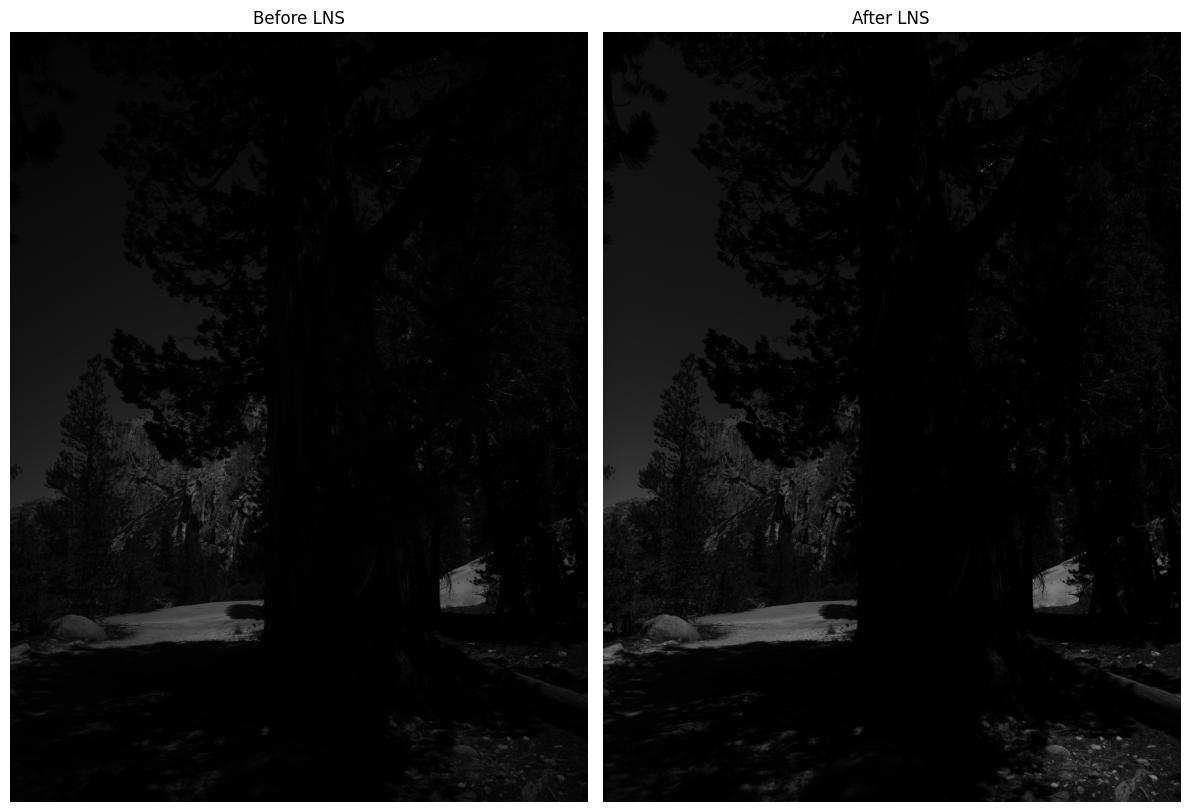

In [11]:
rotate = lambda x: np.rot90(x, k=3)

ref_img = rotate(processed_imgs[0])
corr_img = rotate(corrected_imgs[0])
imgs = (ref_img, corr_img)
titles = ("Before LNS", "After LNS")
plot_images(imgs, titles)

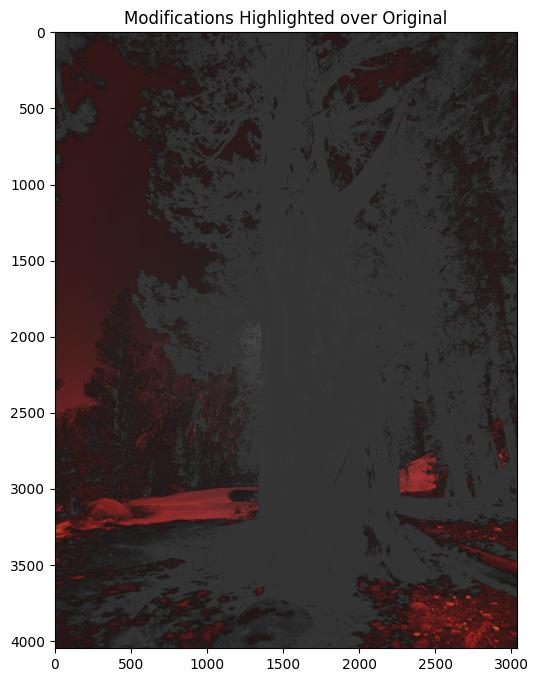

In [9]:
plt.figure(figsize=(8, 8))

diff = np.abs(ref_img - corr_img)
vmax = diff.max()

# Show the original in grayscale
plt.imshow(ref_img, cmap="gray", alpha=0.8)

# Create a masked array to hide "zero" differences (transparency)
masked_diff = np.ma.masked_where(np.abs(diff) < (vmax * 0.01), diff)

# Overlay the significant differences
plt.imshow(masked_diff, cmap="hot", alpha=0.6)
plt.title("Modifications Highlighted over Original")
plt.show()